# Problem Statement

FNC-1 was designed as a stance detection dataset and it contains 75,385 labeled headline and article pairs. The pairs are labelled as either agree, disagree, discuss, and unrelated. Each headline in the dataset is phrased as a statement



# Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical,plot_model

from keras.models import Input,Model,Sequential
from keras.layers import LSTM,Embedding,Dropout,Activation,Reshape,Dense,GRU,Add,Flatten,concatenate

from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences


# Dataset Preparation

In [3]:
data =pd.read_csv("/kaggle/input/lemma-data/lemmatized_dataset.csv")

In [4]:
data['stance_cat'] = data['Stance'].map({'agree':0,'disagree':1,'discuss':2,'unrelated':3}).astype(int)
data['Stance'].value_counts()
#'agree':0,'disagree':1,'discuss':2,'unrelated':3

unrelated    36545
discuss       8909
agree         3678
disagree       840
Name: Stance, dtype: int64

In [5]:
#details of corpus

corpus = np.r_[data['Headline'].values,data['articleBody'].values]
print(len(corpus)) # first 49972 contains the Headline and next 49972 contains the articleBody

vocabulary = []
for sentence in corpus:
    vocabulary.extend(sentence.split(' '))

vocabulary = list(set(vocabulary))
vocab_length = len(vocabulary)
print("Vocabulary Length is {0}".format(vocab_length))


99944
Vocabulary Length is 23241


In [6]:
data.head()

,Headline,Body ID,Stance,articleBody,stance_cat
0,police find mass graf with at least 15 body ne...,712,unrelated,danny boyle is directing the untitled film set...,3
1,hundred of palestinian flee flood in gaza a is...,158,agree,hundred of palestinian we are evacuated from t...,0
2,christian bale pass on role of steve job actor...,137,unrelated,30yearold moscow resi wouldent wa hospitalized...,3
3,hbo and apple in talk for 15month apple tv str...,1034,unrelated,reuters a canadian soldier wa shot at the cana...,3
4,spi woulder burrowe would through tourist stom...,1923,disagree,fear not arachnophobes the story of bunburys s...,1


# BASELINE - ONE HOT ENCODING

In [7]:
max_features = 5000
max_nb_words = 24000
EMBEDDING_DIM = 50
MAX_SEQUENCE_LENGTH_HEADLINE = 64
MAX_SEQUENCE_LENGTH_BODY = 64

In [8]:

encoded_docs_headline = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'Headline'].tolist()]
padded_docs_headline = pad_sequences(encoded_docs_headline,MAX_SEQUENCE_LENGTH_HEADLINE,padding='post')

encoded_docs_body = [one_hot(sentence,vocab_length) for sentence in data.loc[:,'articleBody'].tolist()]
padded_docs_body = pad_sequences(encoded_docs_body,MAX_SEQUENCE_LENGTH_BODY,padding='post')


labels = to_categorical(data.loc[:,'stance_cat'])


In [10]:
padded_docs_headline_train = padded_docs_headline[:int(len(padded_docs_headline)*0.8),:]
padded_docs_headline_test = padded_docs_headline[int(len(padded_docs_headline)*0.8):,:]

padded_docs_body_train = padded_docs_body[:int(len(padded_docs_body)*0.8),:]
padded_docs_body_test = padded_docs_body[int(len(padded_docs_body)*0.8):,:]

labels_train = labels[:int(len(labels)*0.8),:]
labels_test = labels[int(len(labels)*0.8):,:]


In [11]:
# Assuming you have your data loaded and processed, and your model is defined as 'model_combined'

# Split the data into training, validation, and test sets
split_index_train = int(len(padded_docs_headline) * 0.8)
split_index_val = int(len(padded_docs_headline) * 0.9)

padded_docs_headline_train = padded_docs_headline[:split_index_train]
padded_docs_headline_val = padded_docs_headline[split_index_train:split_index_val]
padded_docs_headline_test = padded_docs_headline[split_index_val:]

padded_docs_body_train = padded_docs_body[:split_index_train]
padded_docs_body_val = padded_docs_body[split_index_train:split_index_val]
padded_docs_body_test = padded_docs_body[split_index_val:]

labels_train = labels[:split_index_train]
labels_val = labels[split_index_train:split_index_val]
labels_test = labels[split_index_val:]



# Defining Model Architecture

In [68]:
from keras.layers import Bidirectional

input_headline = Input(shape=[64], name='input_headline')
embedding_headline = Embedding(vocab_length, 50, input_length=MAX_SEQUENCE_LENGTH_HEADLINE)(input_headline)

input_body = Input(shape=[64], name='input_body')
embedding_body = Embedding(vocab_length, 50, input_length=MAX_SEQUENCE_LENGTH_BODY)(input_body)

addition_layer = concatenate([embedding_headline, embedding_body])

# Change LSTM to Bidirectional LSTM
lstm = Bidirectional(LSTM(units=64))(addition_layer)

output = Dense(4, activation='sigmoid')(lstm)

model_combined = Model(inputs=[input_headline, input_body], outputs=output)

model_combined.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


# Model Architecture

In [69]:
model_combined.summary()

Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_headline (InputLayer)     [(None, 64)]         0                                            
__________________________________________________________________________________________________
input_body (InputLayer)         [(None, 64)]         0                                            
__________________________________________________________________________________________________
embedding_10 (Embedding)        (None, 64, 50)       1162050     input_headline[0][0]             
__________________________________________________________________________________________________
embedding_11 (Embedding)        (None, 64, 50)       1162050     input_body[0][0]                 
____________________________________________________________________________________________

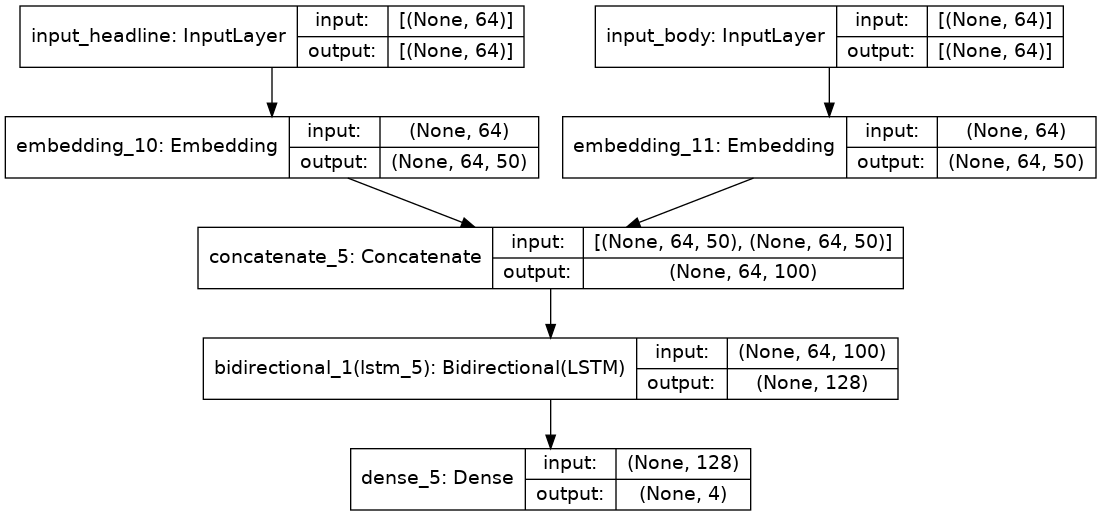

In [71]:
plot_model(model_combined, to_file='model_one_hot.png', show_shapes=True, show_layer_names=True)


# Model Training

Epoch 1/15
1250/1250 [==============================] - 28s 20ms/step - loss: 0.7057 - accuracy: 0.7582 - val_loss: 0.4658 - val_accuracy: 0.8275
Epoch 2/15
1250/1250 [==============================] - 24s 19ms/step - loss: 0.4008 - accuracy: 0.8494 - val_loss: 0.3625 - val_accuracy: 0.8577
Epoch 3/15
1250/1250 [==============================] - 23s 18ms/step - loss: 0.2951 - accuracy: 0.8861 - val_loss: 0.2957 - val_accuracy: 0.8879
Epoch 4/15
1250/1250 [==============================] - 24s 19ms/step - loss: 0.2070 - accuracy: 0.9208 - val_loss: 0.2599 - val_accuracy: 0.9057
Epoch 5/15
1250/1250 [==============================] - 23s 18ms/step - loss: 0.1568 - accuracy: 0.9400 - val_loss: 0.2411 - val_accuracy: 0.9115
Epoch 6/15
1250/1250 [==============================] - 23s 19ms/step - loss: 0.1210 - accuracy: 0.9545 - val_loss: 0.2446 - val_accuracy: 0.9107
Epoch 7/15
1250/1250 [==============================] - 23s 18ms/step - loss: 0.0848 - accuracy: 0.9692 - val_loss: 0.2267 -

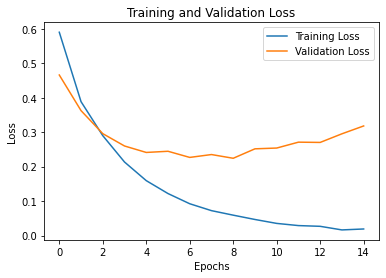

157/157 [==============================] - 1s 4ms/step - loss: 0.2862 - accuracy: 0.9386
Test Loss: 0.28615278005599976
Test Accuracy: 0.9385754466056824


In [72]:
import matplotlib.pyplot as plt

# Train the model with training and validation sets
history = model_combined.fit([padded_docs_headline_train, padded_docs_body_train], labels_train, 
                              epochs=15, verbose=1, 
                              validation_data=([padded_docs_headline_val, padded_docs_body_val], labels_val))

# Save the training history
training_loss = history.history['loss']
validation_loss = history.history['val_loss']

# Plot the loss
plt.plot(training_loss, label='Training Loss')
plt.plot(validation_loss, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Evaluate the model on the test set
loss, accuracy = model_combined.evaluate([padded_docs_headline_test, padded_docs_body_test], labels_test)
print('Test Loss:', loss)
print('Test Accuracy:', accuracy)



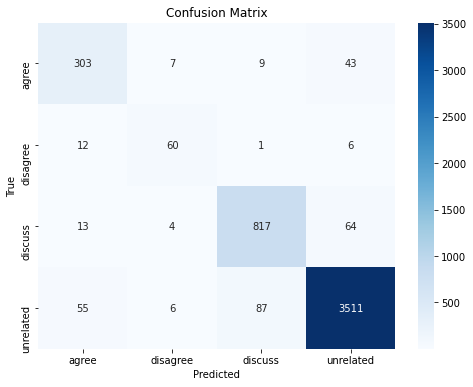

In [73]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

# Assuming 'model_combined' is your trained model

# Get predictions on the test set
predictions = model_combined.predict([padded_docs_headline_test, padded_docs_body_test])
predicted_labels = np.argmax(predictions, axis=1)

# Compute the confusion matrix
conf_matrix = confusion_matrix(labels_test.argmax(axis=1), predicted_labels)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['agree', 'disagree', 'discuss', 'unrelated'],
            yticklabels=['agree', 'disagree', 'discuss', 'unrelated'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()



In [74]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support

# Calculate accuracy
RELATED = [0,1,2]
#'agree':0,'disagree':1,'discuss':2,'unrelated':3
accuracy = accuracy_score(labels_test.argmax(axis=1), predicted_labels)

# Calculate precision, recall, F1-score using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average='weighted')

# Define your custom score function
def score_submission(gold_labels, test_labels):
    score = 0.0

    for i, (g, t) in enumerate(zip(gold_labels, test_labels)):
        g_stance, t_stance = g, t
        if g_stance == t_stance:
            score += 0.25
            if g_stance != 'unrelated':
                score += 0.50
        if g_stance in RELATED and t_stance in RELATED:
            score += 0.25


    return score


def report_score(actual,predicted):
    score = score_submission(actual,predicted)
    best_score = score_submission(actual,actual)

    print("Score: " +str(score) + " out of " + str(best_score) + "\t("+str(score*100/best_score) + "%)")
    return score*100/best_score


# Calculate your custom score
custom_score = score_submission(labels_test.argmax(axis=1), predicted_labels)
report_sc = report_score(labels_test.argmax(axis=1), predicted_labels)

# Print all the metrics
# print("Accuracy:", accuracy)
# print("Precision:", precision)
# print("Recall:", recall)
# print("F1 Score:", f1_score)
print("Custom Score:", custom_score)


Score: 3824.75 out of 4083.25	(93.66925855629707%)
Custom Score: 3824.75


In [75]:
print(labels_test.argmax(axis=1))


[3 3 3 ... 0 2 3]


In [76]:
print(predicted_labels)

[3 3 3 ... 0 2 3]


In [77]:
from sklearn.metrics import precision_recall_fscore_support

# Calculate precision, recall, F1-score for each class using scikit-learn
precision, recall, f1_score, _ = precision_recall_fscore_support(labels_test.argmax(axis=1), predicted_labels, average=None)

# Print class-wise F1 scores
for i in range(len(precision)):
    print(f"Class {i} - Precision: {precision[i]}, Recall: {recall[i]}, F1-score: {f1_score[i]}")

# Print all the metrics
print("Accuracy:", accuracy)
print("Macro Precision:", precision.mean())
print("Macro Recall:", recall.mean())
print("Macro F1 Score:", f1_score.mean())
print("Custom Score:", custom_score)


Class 0 - Precision: 0.7911227154046997, Recall: 0.8370165745856354, F1-score: 0.8134228187919463
Class 1 - Precision: 0.7792207792207793, Recall: 0.759493670886076, F1-score: 0.7692307692307693
Class 2 - Precision: 0.8938730853391685, Recall: 0.9097995545657016, F1-score: 0.9017660044150111
Class 3 - Precision: 0.9688189845474614, Recall: 0.9595517901065865, F1-score: 0.964163119593574
Accuracy: 0.9385754301720688
Macro Precision: 0.8582588911280272
Macro Recall: 0.8664653975359999
Macro F1 Score: 0.8621456780078252
Custom Score: 3824.75


**Please upvote the notebook if you find it useful**